In [4]:
#!pip install fedot

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "10"
os.environ["NUMEXPR_NUM_THREADS"] = "10"
os.environ["OMP_NUM_THREADS"] = "10"

import torch
torch.set_num_threads(10)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.raiseExceptions = False

import fedot
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
import inspect

In [6]:
from google.colab import files
uploaded = files.upload()

Saving ts study 1.txt to ts study 1.txt


In [21]:
ts_tabular =pd.read_csv('ts study 1.txt')
ts_real_temp = ts_tabular[ts_tabular['label']=='temp'].drop('label',axis=1)['value'].to_numpy()
ts_real_traffic = ts_tabular[ts_tabular['label']=='traffic_volume'].drop('label',axis=1)['value'].to_numpy()

In [8]:
def s1(n,noise = 3,sign=1):
    def f1(x):
        return 5*np.sin(x/20)+0.1*x-2*np.sqrt(x)
    trend = f1(np.array(range(n)))
    noise = np.random.normal(loc = 0, scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend' : trend*sign}
    return ans
def s2(length, periods = 10,noise = 0.3,sign=1 ):

    sinusoidal_data = np.linspace(-periods * np.pi, periods * np.pi, length)
    sinusoidal_data = np.sin(sinusoidal_data)
    cos_1_data = np.linspace(-periods * np.pi/2, periods/2 * np.pi/2, int(length/2))
    cos_1_data = np.cos(cos_1_data) 
    cos_2_data = np.linspace(periods/2 * np.pi/2, periods * np.pi/2, int(length/2))
    cos_2_data = np.cos(cos_2_data)   
    cosine_data = np.hstack((cos_1_data, cos_2_data))
    
    random_noise = np.random.normal(loc=0.0, scale=noise, size=length)
    synthetic_data = sinusoidal_data + cosine_data + random_noise
    ans = {'ts':synthetic_data*sign, 'trend': (sinusoidal_data + cosine_data)*sign}
    return ans
def s3(n,noise = 10,sign = 1):
    r = np.array(range(n))
    trend = (r-r/5*np.sin(r/2)+r/2*np.sin(r/20))/10
    noise = np.random.normal(loc=0,scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend': trend*sign}
    return ans
def s4(n,noise = 1,sign =1):
    array = np.array(range(n))
    trend = array/5+np.power(array,0.5)*np.sin(np.pi/12*array)
    noise = np.random.normal(loc = 0,scale = noise, size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign, 'trend' : trend*sign}
    return ans

def s5(n,noise = 1,sign=1):
    r= np.arange(n)
    trend = r*1
    noise = np.random.normal(loc=0,scale = noise,size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign,'trend':trend*sign}
    return ans

def s6(n,noise = 1, sign =1):
    r = np.arange(n)
    trend = 2*np.sin(2*r)+np.cos(r)
    noise = np.random.normal(loc = 0,scale  = noise,size = n)
    ts = trend+noise
    ans = {'ts':ts,'trend':trend}
    return ans

In [41]:
horizon = 30
validation_blocks = 2
task = Task(TaskTypesEnum.ts_forecasting,  TsForecastingParams(forecast_length=horizon))
start = 1000
end = 2000
series = 'traffic'

if series == 'traffic':
  init_series = ts_real_traffic
  ts = init_series[start:end]
  trend = None
  ts_test = init_series[end:end+horizon]
  trend_test = None

if series == 'temp':
    init_series = ts_real_temp
    ts = init_series[start:end]
    trend = None
    ts_test = init_series[end:end+horizon]
    trend_test = None

if series ==1:
    noise = 0.5
    init_series = s1(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]  
    
if series ==2:
    noise = 0.5
    init_series = s2(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==3:
    noise = 0.5
    init_series = s3(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==4:
    noise = 0.5
    init_series = s4(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
  
if series ==5:
    noise = 1
    init_series = s5(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]   

if series ==6:
    noise = 0.5
    init_series = s6(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
 
idx = np.array( range(len(np.array(ts))) )
train_input = InputData(idx=idx,
                            features=ts,
                            target=ts,
                            task=task,
                            data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input, validation_blocks=2)

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting',
                  safe_mode = True,
                  task_params=task.task_params,
                  timeout=3,
                  n_jobs=-1,
                  cv_folds=2, 
                  validation_blocks=2, 
                  preset='ts',
                  with_tuning = False,
                  max_depth = 5,
                  num_of_generations  =3 ,
                  logging_level = 10,
                 show_progress =True)

In [46]:
#inspect.getmembers(model)

INFO:root:AssumptionsHandler - Initial pipeline fitting started


2022-11-24 18:35:59,243 - AssumptionsHandler - Initial pipeline fitting started


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 18:35:59,251 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:35:59,257 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 18:35:59,262 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:35:59,266 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: lagged


2022-11-24 18:35:59,272 - PrimaryNode - Trying to fit primary node with operation: lagged


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: glm


2022-11-24 18:35:59,380 - PrimaryNode - Trying to fit primary node with operation: glm


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:35:59,513 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:35:59,518 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:35:59,521 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:35:59,525 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 18:35:59,531 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 18:35:59,538 - PrimaryNode - Predict in primary node by operation: glm


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2022-11-24 18:35:59,546 - AssumptionsHandler - Initial pipeline was fitted successfully


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 0.3 sec.


2022-11-24 18:35:59,552 - ApiComposer - Initial pipeline was fitted in 0.3 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['pca', 'dtreg', 'gaussian_filter', 'stl_arima', 'ets', 'arima', 'ts_naive_average', 'smoothing', 'glm', 'cut', 'ar', 'fast_ica', 'normalization', 'linear', 'scaling', 'lasso', 'locf', 'ridge', 'polyfit', 'sgdr', 'sparse_lagged', 'diff_filter', 'adareg', 'lagged']


2022-11-24 18:35:59,568 - ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['pca', 'dtreg', 'gaussian_filter', 'stl_arima', 'ets', 'arima', 'ts_naive_average', 'smoothing', 'glm', 'cut', 'ar', 'fast_ica', 'normalization', 'linear', 'scaling', 'lasso', 'locf', 'ridge', 'polyfit', 'sgdr', 'sparse_lagged', 'diff_filter', 'adareg', 'lagged']


CRITICAL:root:ApiComposer - Pipeline composition started.


2022-11-24 18:35:59,608 - ApiComposer - Pipeline composition started.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2022-11-24 18:35:59,611 - DataSourceSplitter - K-folds cross validation is applied.


Generations:  33%|███▎      | 1/3 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:35:59,629 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 1


2022-11-24 18:36:08,626 - EvoGraphOptimizer - Generation num: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1446.7102133142248, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 18:36:08,636 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1446.7102133142248, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 18:36:08,639 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.2 min


2022-11-24 18:36:08,647 - EvoGraphOptimizer - spent time: 0.2 min


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:36:10,188 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 2


2022-11-24 18:36:30,036 - EvoGraphOptimizer - Generation num: 2


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1012.8549857773021, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 18:36:30,042 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1012.8549857773021, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 18:36:30,047 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2022-11-24 18:36:30,050 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 5


2022-11-24 18:36:30,054 - EvoGraphOptimizer - Next population size: 34; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:36:30,889 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 3


2022-11-24 18:36:44,443 - EvoGraphOptimizer - Generation num: 3


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1012.8549857773021, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 18:36:44,449 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1012.8549857773021, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2022-11-24 18:36:44,457 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.7 min


2022-11-24 18:36:44,461 - EvoGraphOptimizer - spent time: 0.7 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 5


2022-11-24 18:36:44,465 - EvoGraphOptimizer - Next population size: 55; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 18:36:45,644 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 4


2022-11-24 18:37:01,576 - EvoGraphOptimizer - Generation num: 4


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1012.8549857773021, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 18:37:01,583 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 1012.8549857773021, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2022-11-24 18:37:01,595 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.0 min


2022-11-24 18:37:01,598 - EvoGraphOptimizer - spent time: 1.0 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2022-11-24 18:37:01,602 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:  33%|███▎      | 1/3 [01:01<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 1.033 min


2022-11-24 18:37:01,607 - OptimisationTimer - Composition time: 1.033 min


INFO:root:GPComposer - GP composition finished


2022-11-24 18:37:01,613 - GPComposer - GP composition finished


CRITICAL:root:ApiComposer - Model generation finished


2022-11-24 18:37:01,993 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2022-11-24 18:37:02,295 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [dtreg, glm, ridge, lagged]}


2022-11-24 18:37:02,301 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [dtreg, glm, ridge, lagged]}


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: dtreg


2022-11-24 18:37:02,312 - SecondaryNode - Obtain prediction in secondary node with operation: dtreg


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: dtreg


2022-11-24 18:37:02,320 - SecondaryNode - Fit all parent nodes in secondary node with operation: dtreg


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 18:37:02,332 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 18:37:02,336 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 18:37:02,340 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 18:37:02,348 - PrimaryNode - Predict in primary node by operation: glm


2022-11-24 18:37:02,401 - OperationTypesRepository - Operation lagged not found in the repository


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.0.


2022-11-24 18:37:02,505 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.0.


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,510 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


2022-11-24 18:37:02,519 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,528 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,539 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


2022-11-24 18:37:02,543 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,546 - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,549 - findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,553 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,556 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 18:37:02,558 - findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 18:37:02,565 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05


2022-11-24 18:37:02,571 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


2022-11-24 18:37:02,575 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,580 - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,586 - findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


2022-11-24 18:37:02,591 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 18:37:02,593 - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,596 - findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 18:37:02,599 - findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


2022-11-24 18:37:02,607 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 18:37:02,612 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


2022-11-24 18:37:02,617 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,622 - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


2022-11-24 18:37:02,625 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


2022-11-24 18:37:02,628 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,635 - findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,640 - findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,645 - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,650 - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,655 - findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 18:37:02,660 - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 18:37:02,665 - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,669 - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05


2022-11-24 18:37:02,675 - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05


2022-11-24 18:37:02,679 - findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,684 - findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


2022-11-24 18:37:02,692 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,697 - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,704 - findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,707 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 18:37:02,712 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,715 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,722 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25


2022-11-24 18:37:02,724 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 18:37:02,727 - findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 18:37:02,730 - findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 18:37:02,733 - findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


2022-11-24 18:37:02,735 - findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


2022-11-24 18:37:02,738 - findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535


2022-11-24 18:37:02,741 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


2022-11-24 18:37:02,743 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535


2022-11-24 18:37:02,746 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Humor Sans' (Humor-Sans.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,749 - findfont: score(<Font 'Humor Sans' (Humor-Sans.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05


2022-11-24 18:37:02,752 - findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25


2022-11-24 18:37:02,754 - findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Italic.ttf) italic normal 400 condensed>) = 11.25


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.0 to DejaVu Sans ('/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


2022-11-24 18:37:02,757 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.0 to DejaVu Sans ('/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


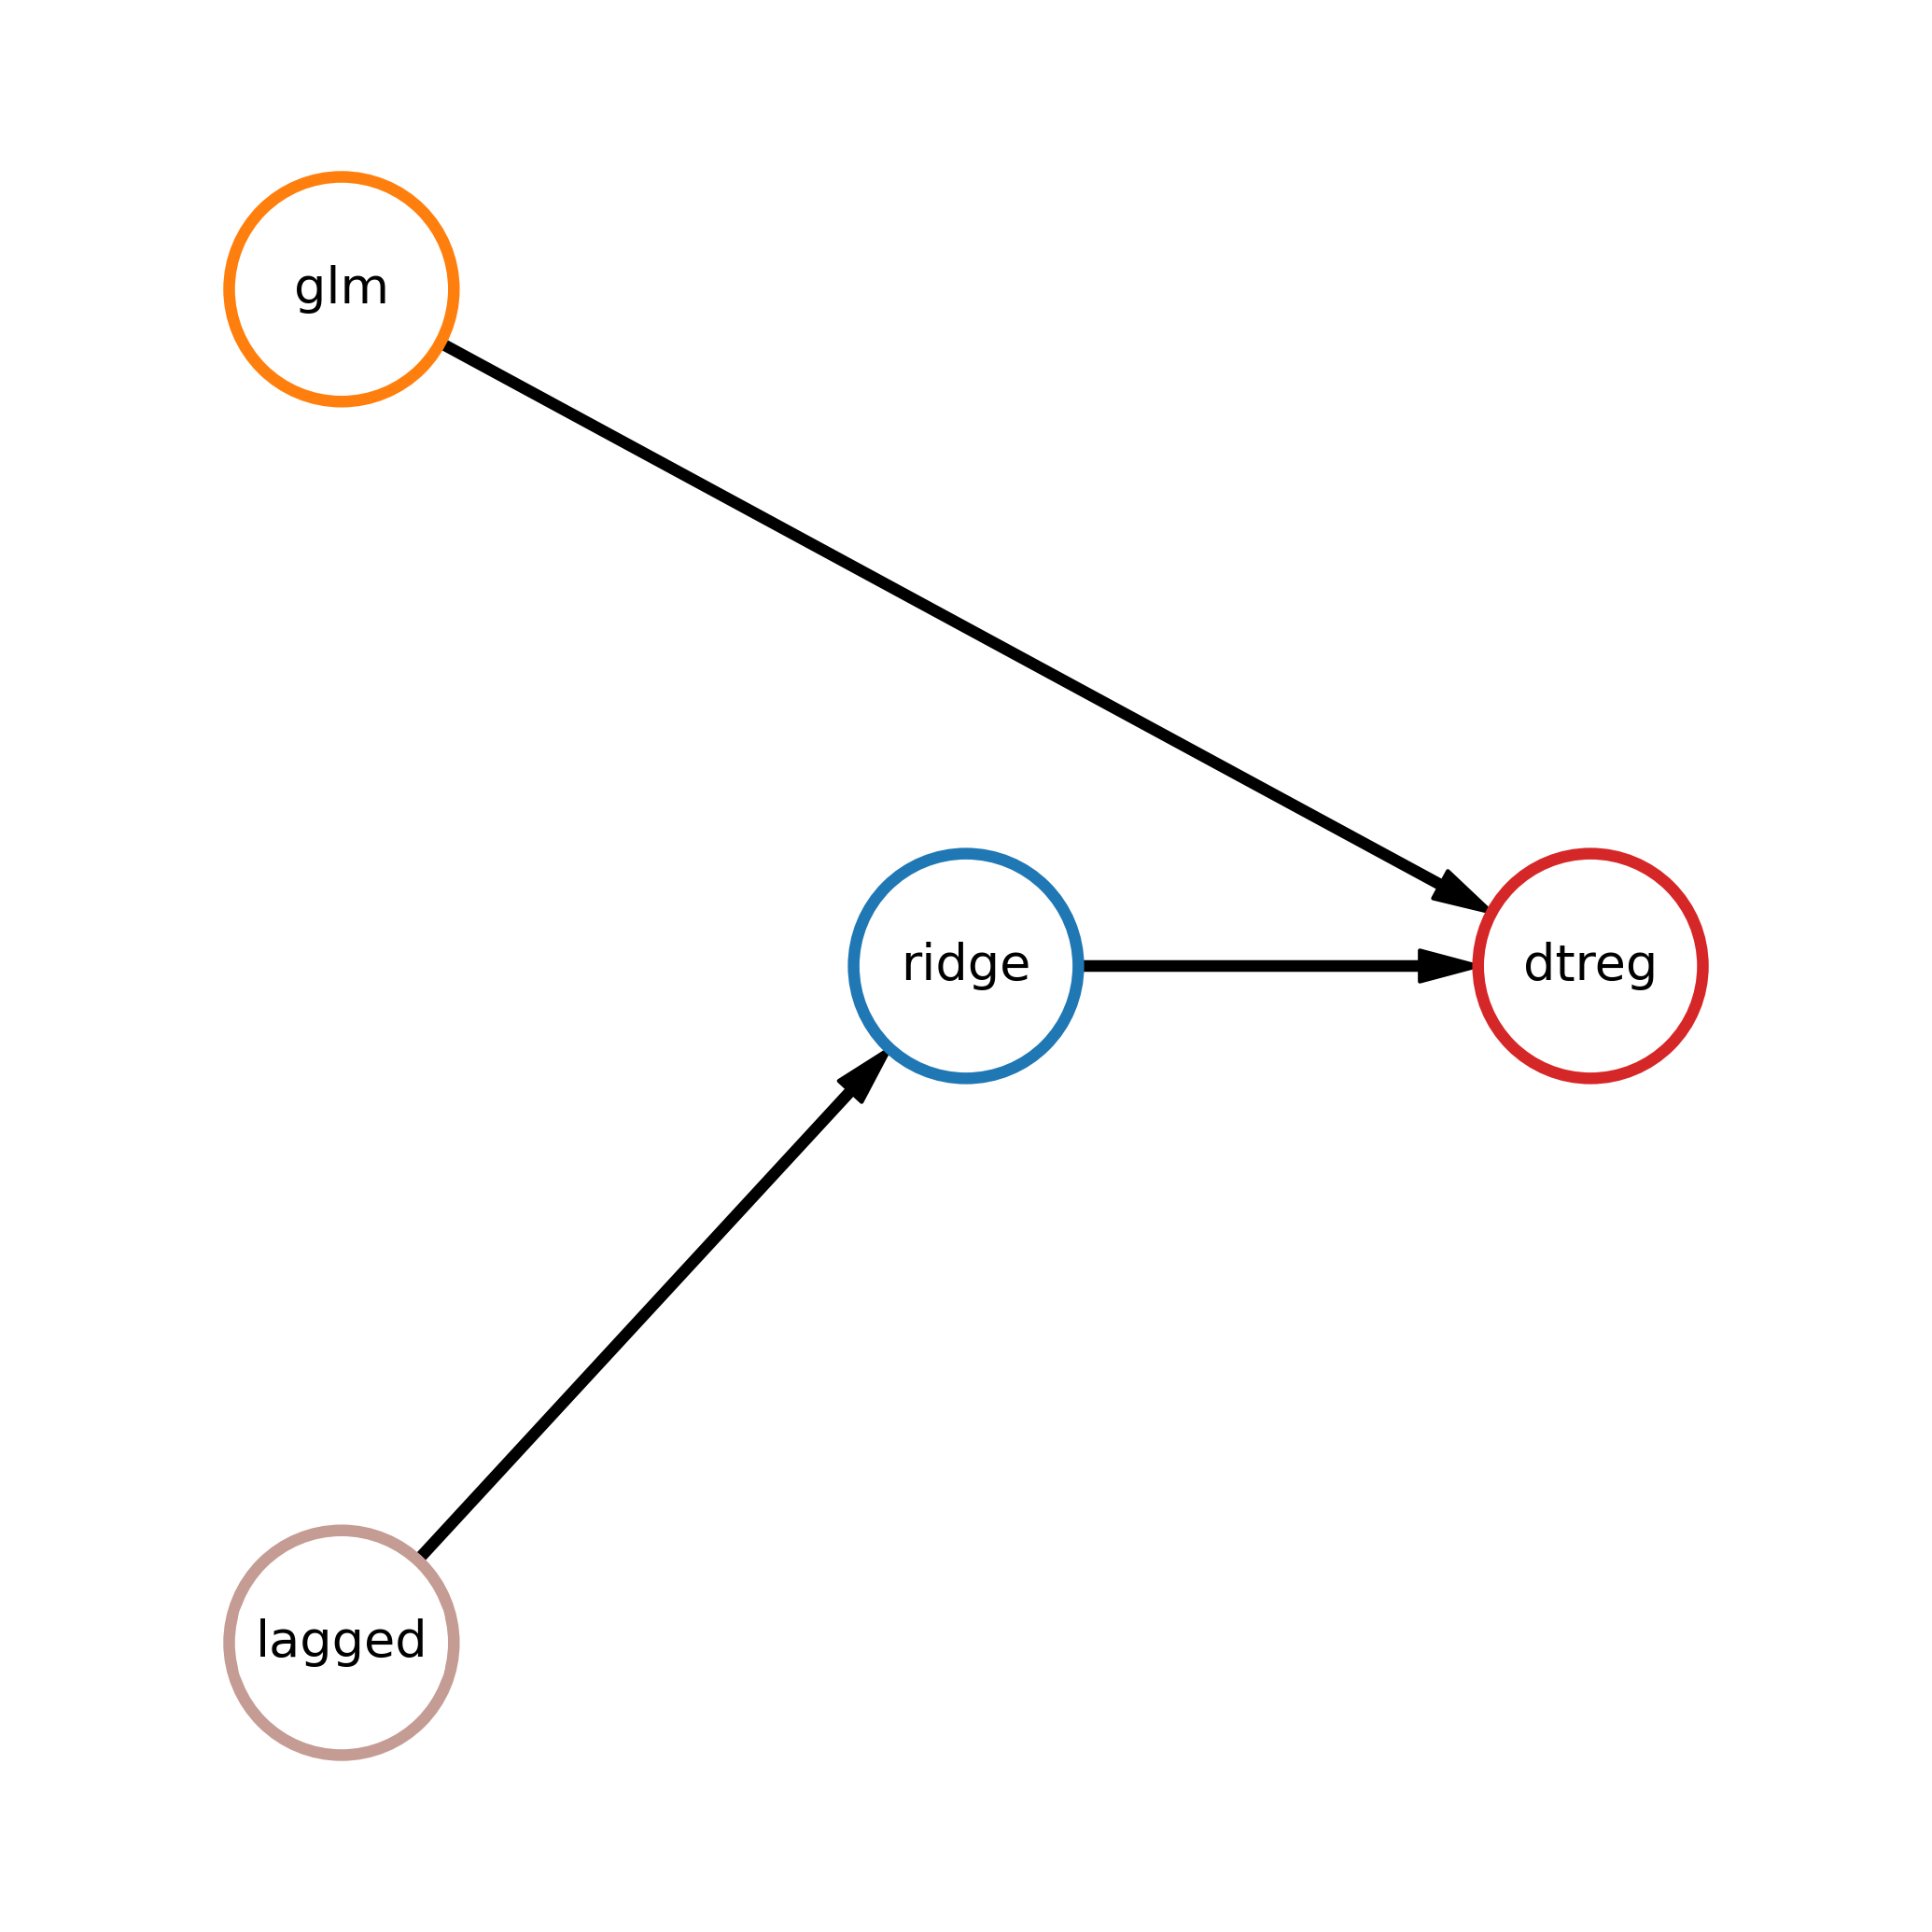

In [42]:
pipeline = model.fit(train_data)
forecast = model.forecast(test_data)
pipeline.show()

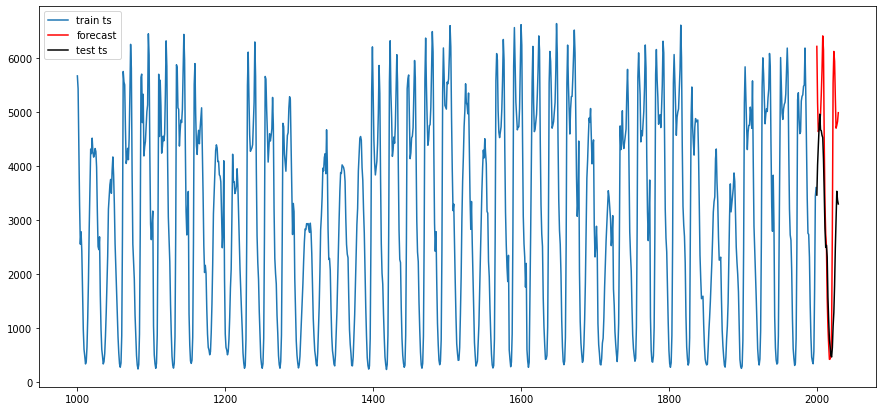

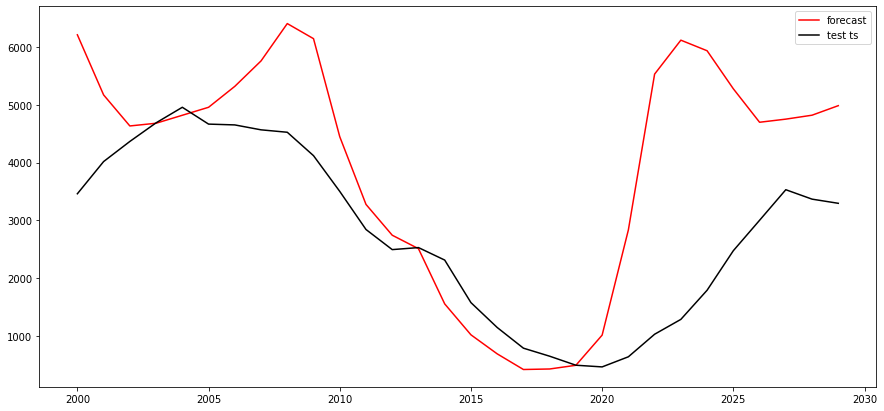

In [43]:
fig,ax  = plt.subplots()
fig.set(figwidth = 15,figheight = 7)
test_range = range(len(ts), len(ts)+len(ts_test))
test_range = range(end,end+horizon)
train_range = range(start,end)
total_range = range(start,end+horizon)

ax.plot(train_range,ts, label = 'train ts')
if trend is not None:
    ax.plot(train_range, trend,color = 'green',label = 'trend')
if trend_test is not None:
    ax.plot(test_range, trend_test,color = 'green')
ax.plot(test_range,forecast, color = 'red', label = 'forecast')
ax.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

fig1,ax1 = plt.subplots()
fig1.set(figwidth = 15,figheight = 7)

if trend_test is not None:
    ax1.plot(test_range, trend_test,color = 'green')
ax1.plot(test_range,forecast, color = 'red', label = 'forecast')
ax1.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

In [44]:
import sys
from sklearn.metrics import mean_squared_error as mse
from fedot.core.composer.metrics import QualityMetric
from fedot.core.data.data import InputData, OutputData
from fedot.core.repository.tasks import TsForecastingParams

def quantile_loss(y_true, y_pred, quantile=0.5):
    res = np.array(y_true)-np.array(y_pred)
    metrics=np.empty(shape = [0])
    for x in res:
        if x>=0:
            metrics = np.append(metrics, quantile*x)
        else:
            metrics = np.append(metrics,(quantile-1)*x)
    return np.mean(metrics)

class Quantile_Loss_1(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.1)
        return value


class Quantile_Loss_9(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.9)
        return value

In [45]:
#importing for tuning
from fedot.core.optimisers.adapters import PipelineAdapter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.pipelines.tuning.tuner_interface import HyperoptTuner
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.optimisers.composer_requirements import ComposerRequirements
import datetime

from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

#these parameters are the same for both tuners below
task = Task(TaskTypesEnum.ts_forecasting,TsForecastingParams(forecast_length=horizon))
composer_requirements = ComposerRequirements()
composer_requirements.validation_blocks = 2
composer_requirements.n_jobs= -1
composer_requirements.show_progress = True

#this tuner will be used to create lower confidence interval
low_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_1.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

#this tuner will be used to create uppper confidence interval
up_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_9.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 18:42:31,244 - DataSourceSplitter - Hold out validation is applied.


INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 18:42:31,253 - DataSourceSplitter - Hold out validation is applied.


In [46]:
def quantile_maker(quantile,arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    up = []
    low = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        q_up = np.quantile(x, 1-quantile)
        up.append(q_up)
        q_low = np.quantile(x,quantile)
        low.append(q_low)
    up = np.array(up)
    low = np.array(low)
    return {'up':up,'low':low}

def mean_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    average = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        average.append(x.mean())
    return average

def median_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    median = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        median.append(np.median(x))
    return median

def absolute_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    maximum = []
    minimum = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        maximum.append(np.max(x))
        minimum.append(np.min(x))
    return {'up':np.array(maximum),'low':np.array(minimum)}

from scipy.stats import trim_mean
def truncated_mean_maker(arrays, quantile=0.1):
    number_arrays = len(arrays)
    l = len(arrays[0])
    trunc_mean = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        trunc_mean.append(trim_mean(x, quantile))
    return np.array(trunc_mean)

In [47]:
def conf_int_maker(model = model,
                   train_ts = ts,
                   number_models = 10, 
                   pipelines_show= False):
    """
    model - a fedot model of interest
    train_ts - the ts used for training the model
    ts_test - the testing series; used for plotting and visualization of the results
    number_models - number of models used to create the confidence intervals
    regim - type of getting lower and upper confidence intervals from the upper and lower arrays; 
            default is 'quantile' also avaliable 'average' and 'median', 'absolute_bounds', 'truncated_mean'
    plot - boolean parameter indicating wheter to show plot of the forecast and confidence intervals
    plot_history - boolean parameter indicating whether to show previous series
    """
    
    horizon = model.params.task.task_params.forecast_length
    train_data = model.train_data
    test_data = model.test_data
    forecast = model.predict(test_data)

    #4 lines below allow us take the best models
    fits = []
    for ind in model.history.individuals[-1]:
        fits.append(ind.fitness.value)
    fits = np.sort(np.array(fits))

    #create up and low predictions
    up_predictions = []
    low_predictions = []
    
    s=1
    for ind in model.history.individuals[-1]:
        if ind.fitness.value<=fits[number_models]:
            pipeline = PipelineAdapter().restore(ind.graph)
            print(f'Fitting pipeline №{s}')
            s+=1
            if pipelines_show:
                pipeline.show()
            
            
            #tuning upper confidence interval
            tuned_pipeline = up_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            up_predictions.append(preds)
            del tuned_pipeline
            
            #tuning lower confidence interval
            tuned_pipeline = low_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            low_predictions.append(preds)
            del tuned_pipeline
    return {'up_predictions':up_predictions, 'low_predictions':low_predictions}

In [48]:
def conf_int_plotting(up_predictions,
                      low_predictions,
                      horizon=horizon,
                      forecast=forecast,
                      ts=ts,
                      ts_test=ts_test,
                      trend_test=trend_test,
                      regim = 'quantile',
                      plot_history = True,
                      plot_up_int = True,
                      plot_low_int = True,
                      plot_trend = True,
                      plot_forecast = True,
                      plot_upper_train = True,
                      plot_lower_train = True,
                      plot_ts_test = True):
    if regim == 'quantile':
        up_res= quantile_maker(quantile = 0.1, arrays = up_predictions)['up']
        low_res= quantile_maker(quantile = 0.1, arrays = low_predictions)['low']
    if regim == 'mean':
        up_res = mean_maker(arrays = up_predictions)
        low_res = mean_maker(arrays = low_predictions)
    if regim == 'median':
        up_res = median_maker(arrays = up_predictions)
        low_res = median_maker(arrays = low_predictions)
    if regim == 'absolute_bounds':
        up_res = absolute_maker(arrays = up_predictions)['up']
        low_res = absolute_maker(arrays = low_predictions)['low']
    if regim == 'truncated_mean':
        up_res = truncated_mean_maker(arrays = up_predictions)
        low_res = truncated_mean_maker(arrays = low_predictions)
    
    up = np.maximum(up_res,forecast)  
    low = np.minimum(low_res,forecast)

    r = range(1,horizon+1)
    fig,ax = plt.subplots()
    fig.set(figwidth = 15,figheight = 7)
    for i in range(len(up_predictions)):
        if i==0:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow',label = 'preds for up train')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink',label = 'preds for low train')
        else:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink')    
    if plot_up_int:
        ax.plot(r,up, color = 'blue', label  = 'Up',marker= '.')
    if plot_low_int:
        ax.plot(r,low, color = 'green', label  = 'Low',marker = '.')
    if plot_forecast:
        ax.plot(r,forecast, color = 'red', label = 'Forecast')
    if ts_test is not None:
        if plot_ts_test:
            ax.plot(r,ts_test,color = 'black', label = 'Actual TS')
    if trend_test is not None:
        if plot_trend:
            ax.plot(r, trend_test, color = 'magenta', label = 'True Trend')
    plt.legend()
    if plot_history:
        fig1,ax1 = plt.subplots()
        
        fig1.set(figwidth = 15,figheight = 7)
       
        train_range = range(len(ts))
        test_range = range(len(ts),len(ts)+horizon)
        
        ax1.plot(train_range,ts, color = 'gray',label = 'Train ts')
        ax1.plot(test_range, up,color = 'blue', label = 'Up')
        ax1.plot(test_range, low,color = 'green', label = 'Low')
        ax1.plot(test_range,forecast, color = 'red', label = 'Forecast')
        if ts_test is not None:
            ax1.plot(test_range, ts_test,color = 'black', label = 'Actual TS')  
        if trend_test is not None:
            ax1.plot(test_range, trend_test, color = 'magenta', label = 'True Trend')
        plt.legend();

In [49]:
x = conf_int_maker(model = model, number_models =7,pipelines_show = False)

INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №1
2022-11-24 18:42:38,236 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006740 seconds


2022-11-24 18:42:38,762 - build_posterior_wrapper took 0.006740 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:42:38,769 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.66trial/s, best loss: 996.2105748077133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010346 seconds


2022-11-24 18:42:39,374 - build_posterior_wrapper took 0.010346 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 996.210575


2022-11-24 18:42:39,382 - TPE using 1/1 trials with best loss 996.210575
 20%|██        | 2/10 [00:03<00:14,  1.86s/trial, best loss: 345.00136217948716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015967 seconds


2022-11-24 18:42:42,121 - build_posterior_wrapper took 0.015967 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 345.001362


2022-11-24 18:42:42,130 - TPE using 2/2 trials with best loss 345.001362
 30%|███       | 3/10 [00:04<00:09,  1.37s/trial, best loss: 345.00136217948716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010934 seconds


2022-11-24 18:42:42,898 - build_posterior_wrapper took 0.010934 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 345.001362


2022-11-24 18:42:42,904 - TPE using 3/3 trials with best loss 345.001362
 40%|████      | 4/10 [00:04<00:06,  1.12s/trial, best loss: 345.00136217948716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005488 seconds


2022-11-24 18:42:43,623 - build_posterior_wrapper took 0.005488 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 345.001362


2022-11-24 18:42:43,630 - TPE using 4/4 trials with best loss 345.001362
 50%|█████     | 5/10 [00:05<00:05,  1.01s/trial, best loss: 345.00136217948716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006790 seconds


2022-11-24 18:42:44,434 - build_posterior_wrapper took 0.006790 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 345.001362


2022-11-24 18:42:44,444 - TPE using 5/5 trials with best loss 345.001362
 60%|██████    | 6/10 [00:06<00:03,  1.02trial/s, best loss: 325.50385714285716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008678 seconds


2022-11-24 18:42:45,353 - build_posterior_wrapper took 0.008678 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 325.503857


2022-11-24 18:42:45,360 - TPE using 6/6 trials with best loss 325.503857
 70%|███████   | 7/10 [00:06<00:02,  1.31trial/s, best loss: 325.50385714285716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006790 seconds


2022-11-24 18:42:45,671 - build_posterior_wrapper took 0.006790 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 325.503857


2022-11-24 18:42:45,676 - TPE using 7/7 trials with best loss 325.503857
 80%|████████  | 8/10 [00:07<00:01,  1.21trial/s, best loss: 325.50385714285716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009160 seconds


2022-11-24 18:42:46,639 - build_posterior_wrapper took 0.009160 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 325.503857


2022-11-24 18:42:46,645 - TPE using 8/8 trials with best loss 325.503857
 90%|█████████ | 9/10 [00:08<00:00,  1.44trial/s, best loss: 325.50385714285716]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006346 seconds


2022-11-24 18:42:47,037 - build_posterior_wrapper took 0.006346 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 325.503857


2022-11-24 18:42:47,047 - TPE using 9/9 trials with best loss 325.503857
100%|██████████| 10/10 [00:09<00:00,  1.05trial/s, best loss: 325.50385714285716]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:42:48,890 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 325.504 worse than initial (+ 5% deviation) 239.617


2022-11-24 18:42:48,897 - PipelineTuner - Return init pipeline due to the fact that obtained metric 325.504 worse than initial (+ 5% deviation) 239.617


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:42:49,106 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008411 seconds


2022-11-24 18:42:49,677 - build_posterior_wrapper took 0.008411 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:42:49,683 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.21trial/s, best loss: 209.0653715277778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009802 seconds


2022-11-24 18:42:50,509 - build_posterior_wrapper took 0.009802 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 209.065372


2022-11-24 18:42:50,516 - TPE using 1/1 trials with best loss 209.065372
 20%|██        | 2/10 [00:03<00:13,  1.72s/trial, best loss: 209.0653715277778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008312 seconds


2022-11-24 18:42:52,857 - build_posterior_wrapper took 0.008312 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 209.065372


2022-11-24 18:42:52,863 - TPE using 2/2 trials with best loss 209.065372
 30%|███       | 3/10 [00:04<00:10,  1.56s/trial, best loss: 209.0653715277778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009824 seconds


2022-11-24 18:42:54,219 - build_posterior_wrapper took 0.009824 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 209.065372


2022-11-24 18:42:54,227 - TPE using 3/3 trials with best loss 209.065372
 40%|████      | 4/10 [00:05<00:08,  1.40s/trial, best loss: 209.0653715277778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008205 seconds


2022-11-24 18:42:55,389 - build_posterior_wrapper took 0.008205 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 209.065372


2022-11-24 18:42:55,396 - TPE using 4/4 trials with best loss 209.065372
 50%|█████     | 5/10 [00:08<00:08,  1.73s/trial, best loss: 209.0653715277778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008110 seconds


2022-11-24 18:42:57,699 - build_posterior_wrapper took 0.008110 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 209.065372


2022-11-24 18:42:57,706 - TPE using 5/5 trials with best loss 209.065372
 60%|██████    | 6/10 [00:08<00:05,  1.26s/trial, best loss: 209.0653715277778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007230 seconds


2022-11-24 18:42:58,033 - build_posterior_wrapper took 0.007230 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 209.065372


2022-11-24 18:42:58,040 - TPE using 6/6 trials with best loss 209.065372
 70%|███████   | 7/10 [00:08<00:02,  1.02trial/s, best loss: 209.0653715277778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008398 seconds


2022-11-24 18:42:58,445 - build_posterior_wrapper took 0.008398 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 209.065372


2022-11-24 18:42:58,452 - TPE using 7/7 trials with best loss 209.065372
 80%|████████  | 8/10 [00:10<00:02,  1.32s/trial, best loss: 209.0653715277778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008737 seconds


2022-11-24 18:43:00,501 - build_posterior_wrapper took 0.008737 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 209.065372


2022-11-24 18:43:00,520 - TPE using 8/8 trials with best loss 209.065372
 90%|█████████ | 9/10 [00:11<00:00,  1.00trial/s, best loss: 209.0653715277778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005078 seconds


2022-11-24 18:43:00,792 - build_posterior_wrapper took 0.005078 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 209.065372


2022-11-24 18:43:00,802 - TPE using 9/9 trials with best loss 209.065372
100%|██████████| 10/10 [00:11<00:00,  1.17s/trial, best loss: 119.89648148148149]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:43:01,892 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 119.896 equal or better than initial (+ 5% deviation) 144.793


2022-11-24 18:43:01,898 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 119.896 equal or better than initial (+ 5% deviation) 144.793


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №2
2022-11-24 18:43:02,391 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008763 seconds


2022-11-24 18:43:02,699 - build_posterior_wrapper took 0.008763 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:43:02,708 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.18trial/s, best loss: 240.56709375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004378 seconds


2022-11-24 18:43:03,546 - build_posterior_wrapper took 0.004378 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 240.567094


2022-11-24 18:43:03,555 - TPE using 1/1 trials with best loss 240.567094
 20%|██        | 2/10 [00:01<00:06,  1.16trial/s, best loss: 240.56709375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005803 seconds


2022-11-24 18:43:04,426 - build_posterior_wrapper took 0.005803 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 240.567094


2022-11-24 18:43:04,434 - TPE using 2/2 trials with best loss 240.567094
 30%|███       | 3/10 [00:02<00:05,  1.30trial/s, best loss: 240.56709375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006719 seconds


2022-11-24 18:43:05,075 - build_posterior_wrapper took 0.006719 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 240.567094


2022-11-24 18:43:05,081 - TPE using 3/3 trials with best loss 240.567094
 40%|████      | 4/10 [00:03<00:05,  1.03trial/s, best loss: 240.56709375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009099 seconds


2022-11-24 18:43:06,361 - build_posterior_wrapper took 0.009099 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 240.567094


2022-11-24 18:43:06,368 - TPE using 4/4 trials with best loss 240.567094
 50%|█████     | 5/10 [00:03<00:03,  1.37trial/s, best loss: 240.56709375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008906 seconds


2022-11-24 18:43:06,666 - build_posterior_wrapper took 0.008906 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 240.567094


2022-11-24 18:43:06,674 - TPE using 5/5 trials with best loss 240.567094
 60%|██████    | 6/10 [00:04<00:02,  1.47trial/s, best loss: 240.56709375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007939 seconds


2022-11-24 18:43:07,241 - build_posterior_wrapper took 0.007939 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 240.567094


2022-11-24 18:43:07,247 - TPE using 6/6 trials with best loss 240.567094
 70%|███████   | 7/10 [00:05<00:02,  1.30trial/s, best loss: 201.25978174603176]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004238 seconds


2022-11-24 18:43:08,187 - build_posterior_wrapper took 0.004238 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 201.259782


2022-11-24 18:43:08,198 - TPE using 7/7 trials with best loss 201.259782
 80%|████████  | 8/10 [00:06<00:01,  1.19trial/s, best loss: 201.25978174603176]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008168 seconds


2022-11-24 18:43:09,181 - build_posterior_wrapper took 0.008168 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 201.259782


2022-11-24 18:43:09,188 - TPE using 8/8 trials with best loss 201.259782
 90%|█████████ | 9/10 [00:07<00:00,  1.12trial/s, best loss: 201.25978174603176]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007676 seconds


2022-11-24 18:43:10,193 - build_posterior_wrapper took 0.007676 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 201.259782


2022-11-24 18:43:10,199 - TPE using 9/9 trials with best loss 201.259782
100%|██████████| 10/10 [00:09<00:00,  1.03trial/s, best loss: 201.25978174603176]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:43:13,368 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 201.260 equal or better than initial (+ 5% deviation) 239.617


2022-11-24 18:43:13,378 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 201.260 equal or better than initial (+ 5% deviation) 239.617


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:43:14,263 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008442 seconds


2022-11-24 18:43:15,199 - build_posterior_wrapper took 0.008442 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:43:15,207 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:08,  1.10trial/s, best loss: 366.80742348579435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008426 seconds


2022-11-24 18:43:16,108 - build_posterior_wrapper took 0.008426 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 366.807423


2022-11-24 18:43:16,115 - TPE using 1/1 trials with best loss 366.807423
 20%|██        | 2/10 [00:03<00:13,  1.66s/trial, best loss: 366.80742348579435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007181 seconds


2022-11-24 18:43:18,295 - build_posterior_wrapper took 0.007181 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 366.807423


2022-11-24 18:43:18,301 - TPE using 2/2 trials with best loss 366.807423
 30%|███       | 3/10 [00:04<00:10,  1.53s/trial, best loss: 366.80742348579435]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007494 seconds


2022-11-24 18:43:19,682 - build_posterior_wrapper took 0.007494 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 366.807423


2022-11-24 18:43:19,688 - TPE using 3/3 trials with best loss 366.807423
 40%|████      | 4/10 [00:06<00:10,  1.68s/trial, best loss: 261.00083333333333]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007340 seconds


2022-11-24 18:43:21,585 - build_posterior_wrapper took 0.007340 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 261.000833


2022-11-24 18:43:21,594 - TPE using 4/4 trials with best loss 261.000833
 50%|█████     | 5/10 [00:07<00:07,  1.58s/trial, best loss: 261.00083333333333]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007482 seconds


2022-11-24 18:43:22,981 - build_posterior_wrapper took 0.007482 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 261.000833


2022-11-24 18:43:22,991 - TPE using 5/5 trials with best loss 261.000833
 60%|██████    | 6/10 [00:08<00:04,  1.18s/trial, best loss: 233.27386178861792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007131 seconds


2022-11-24 18:43:23,384 - build_posterior_wrapper took 0.007131 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 233.273862


2022-11-24 18:43:23,391 - TPE using 6/6 trials with best loss 233.273862
 70%|███████   | 7/10 [00:09<00:03,  1.28s/trial, best loss: 233.27386178861792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010035 seconds


2022-11-24 18:43:24,867 - build_posterior_wrapper took 0.010035 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 233.273862


2022-11-24 18:43:24,883 - TPE using 7/7 trials with best loss 233.273862
 80%|████████  | 8/10 [00:11<00:02,  1.34s/trial, best loss: 161.5170512820513] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007977 seconds


2022-11-24 18:43:26,352 - build_posterior_wrapper took 0.007977 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 161.517051


2022-11-24 18:43:26,367 - TPE using 8/8 trials with best loss 161.517051
 90%|█████████ | 9/10 [00:12<00:01,  1.42s/trial, best loss: 161.5170512820513]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014012 seconds


2022-11-24 18:43:27,936 - build_posterior_wrapper took 0.014012 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 161.517051


2022-11-24 18:43:27,960 - TPE using 9/9 trials with best loss 161.517051
100%|██████████| 10/10 [00:15<00:00,  1.53s/trial, best loss: 161.5170512820513]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:43:31,937 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 161.517 worse than initial (+ 5% deviation) 124.306


2022-11-24 18:43:31,955 - PipelineTuner - Return init pipeline due to the fact that obtained metric 161.517 worse than initial (+ 5% deviation) 124.306


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №3
2022-11-24 18:43:33,231 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003118 seconds


2022-11-24 18:43:33,368 - build_posterior_wrapper took 0.003118 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:43:33,375 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:01,  7.20trial/s, best loss: 340.15950854700844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003529 seconds


2022-11-24 18:43:33,510 - build_posterior_wrapper took 0.003529 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 340.159509


2022-11-24 18:43:33,517 - TPE using 1/1 trials with best loss 340.159509
 20%|██        | 2/10 [00:00<00:01,  5.85trial/s, best loss: 340.15950854700844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003333 seconds


2022-11-24 18:43:33,703 - build_posterior_wrapper took 0.003333 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 340.159509


2022-11-24 18:43:33,710 - TPE using 2/2 trials with best loss 340.159509
 30%|███       | 3/10 [00:00<00:01,  4.08trial/s, best loss: 340.15950854700844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003304 seconds


2022-11-24 18:43:34,037 - build_posterior_wrapper took 0.003304 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 340.159509


2022-11-24 18:43:34,045 - TPE using 3/3 trials with best loss 340.159509
 40%|████      | 4/10 [00:00<00:01,  4.42trial/s, best loss: 340.15950854700844]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003193 seconds


2022-11-24 18:43:34,233 - build_posterior_wrapper took 0.003193 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 340.159509


2022-11-24 18:43:34,239 - TPE using 4/4 trials with best loss 340.159509
 50%|█████     | 5/10 [00:01<00:01,  3.63trial/s, best loss: 173.1551960784314] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003083 seconds


2022-11-24 18:43:34,597 - build_posterior_wrapper took 0.003083 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 173.155196


2022-11-24 18:43:34,603 - TPE using 5/5 trials with best loss 173.155196
 60%|██████    | 6/10 [00:02<00:01,  2.15trial/s, best loss: 173.1551960784314]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003139 seconds


2022-11-24 18:43:35,427 - build_posterior_wrapper took 0.003139 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 173.155196


2022-11-24 18:43:35,434 - TPE using 6/6 trials with best loss 173.155196
 70%|███████   | 7/10 [00:02<00:01,  2.17trial/s, best loss: 173.1551960784314]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003058 seconds


2022-11-24 18:43:35,881 - build_posterior_wrapper took 0.003058 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 173.155196


2022-11-24 18:43:35,891 - TPE using 7/7 trials with best loss 173.155196
 80%|████████  | 8/10 [00:03<00:01,  1.42trial/s, best loss: 173.1551960784314]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003658 seconds


2022-11-24 18:43:37,105 - build_posterior_wrapper took 0.003658 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 173.155196


2022-11-24 18:43:37,119 - TPE using 8/8 trials with best loss 173.155196
 90%|█████████ | 9/10 [00:05<00:00,  1.12trial/s, best loss: 173.1551960784314]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003091 seconds


2022-11-24 18:43:38,425 - build_posterior_wrapper took 0.003091 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 173.155196


2022-11-24 18:43:38,432 - TPE using 9/9 trials with best loss 173.155196
100%|██████████| 10/10 [00:05<00:00,  1.75trial/s, best loss: 173.1551960784314]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:43:39,461 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 173.155 equal or better than initial (+ 5% deviation) 273.622


2022-11-24 18:43:39,465 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 173.155 equal or better than initial (+ 5% deviation) 273.622


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:43:39,769 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003784 seconds


2022-11-24 18:43:40,146 - build_posterior_wrapper took 0.003784 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:43:40,153 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.41trial/s, best loss: 288.0200064599483]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004560 seconds


2022-11-24 18:43:40,565 - build_posterior_wrapper took 0.004560 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 288.020006


2022-11-24 18:43:40,574 - TPE using 1/1 trials with best loss 288.020006
 20%|██        | 2/10 [00:00<00:03,  2.28trial/s, best loss: 288.0200064599483]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003370 seconds


2022-11-24 18:43:41,020 - build_posterior_wrapper took 0.003370 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 288.020006


2022-11-24 18:43:41,029 - TPE using 2/2 trials with best loss 288.020006
 30%|███       | 3/10 [00:02<00:07,  1.02s/trial, best loss: 288.0200064599483]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004139 seconds


2022-11-24 18:43:42,739 - build_posterior_wrapper took 0.004139 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 288.020006


2022-11-24 18:43:42,747 - TPE using 3/3 trials with best loss 288.020006
 40%|████      | 4/10 [00:04<00:07,  1.25s/trial, best loss: 288.0200064599483]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006295 seconds


2022-11-24 18:43:44,333 - build_posterior_wrapper took 0.006295 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 288.020006


2022-11-24 18:43:44,339 - TPE using 4/4 trials with best loss 288.020006
 50%|█████     | 5/10 [00:05<00:07,  1.44s/trial, best loss: 288.0200064599483]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001956 seconds


2022-11-24 18:43:46,119 - build_posterior_wrapper took 0.001956 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 288.020006


2022-11-24 18:43:46,133 - TPE using 5/5 trials with best loss 288.020006
 60%|██████    | 6/10 [00:06<00:04,  1.23s/trial, best loss: 288.0200064599483]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003673 seconds


2022-11-24 18:43:46,938 - build_posterior_wrapper took 0.003673 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 288.020006


2022-11-24 18:43:46,944 - TPE using 6/6 trials with best loss 288.020006
 70%|███████   | 7/10 [00:07<00:03,  1.01s/trial, best loss: 288.0200064599483]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006831 seconds


2022-11-24 18:43:47,505 - build_posterior_wrapper took 0.006831 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 288.020006


2022-11-24 18:43:47,510 - TPE using 7/7 trials with best loss 288.020006
 80%|████████  | 8/10 [00:07<00:01,  1.21trial/s, best loss: 172.40509548611115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002520 seconds


2022-11-24 18:43:47,922 - build_posterior_wrapper took 0.002520 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 172.405095


2022-11-24 18:43:47,929 - TPE using 8/8 trials with best loss 172.405095
 90%|█████████ | 9/10 [00:08<00:00,  1.53trial/s, best loss: 172.40509548611115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001886 seconds


2022-11-24 18:43:48,195 - build_posterior_wrapper took 0.001886 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 172.405095


2022-11-24 18:43:48,202 - TPE using 9/9 trials with best loss 172.405095
100%|██████████| 10/10 [00:08<00:00,  1.21trial/s, best loss: 172.40509548611115]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:43:48,789 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 172.405 equal or better than initial (+ 5% deviation) 416.604


2022-11-24 18:43:48,795 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 172.405 equal or better than initial (+ 5% deviation) 416.604


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №4
2022-11-24 18:43:49,126 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008918 seconds


2022-11-24 18:43:49,380 - build_posterior_wrapper took 0.008918 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:43:49,392 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:02,  3.39trial/s, best loss: 645.945493146188]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009437 seconds


2022-11-24 18:43:49,677 - build_posterior_wrapper took 0.009437 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 645.945493


2022-11-24 18:43:49,696 - TPE using 1/1 trials with best loss 645.945493
 20%|██        | 2/10 [00:02<00:11,  1.45s/trial, best loss: 524.4741434411458]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009810 seconds


2022-11-24 18:43:51,946 - build_posterior_wrapper took 0.009810 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 524.474143


2022-11-24 18:43:51,964 - TPE using 2/2 trials with best loss 524.474143
 30%|███       | 3/10 [00:03<00:09,  1.35s/trial, best loss: 202.66110124482378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008413 seconds


2022-11-24 18:43:53,167 - build_posterior_wrapper took 0.008413 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 202.661101


2022-11-24 18:43:53,179 - TPE using 3/3 trials with best loss 202.661101
 40%|████      | 4/10 [00:05<00:08,  1.34s/trial, best loss: 202.66110124482378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008049 seconds


2022-11-24 18:43:54,497 - build_posterior_wrapper took 0.008049 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 202.661101


2022-11-24 18:43:54,514 - TPE using 4/4 trials with best loss 202.661101
 50%|█████     | 5/10 [00:05<00:05,  1.17s/trial, best loss: 202.66110124482378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015610 seconds


2022-11-24 18:43:55,362 - build_posterior_wrapper took 0.015610 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 202.661101


2022-11-24 18:43:55,375 - TPE using 5/5 trials with best loss 202.661101
 60%|██████    | 6/10 [00:07<00:05,  1.45s/trial, best loss: 202.66110124482378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009963 seconds


2022-11-24 18:43:57,349 - build_posterior_wrapper took 0.009963 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 202.661101


2022-11-24 18:43:57,360 - TPE using 6/6 trials with best loss 202.661101
 70%|███████   | 7/10 [00:08<00:03,  1.16s/trial, best loss: 176.8029782340984] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009792 seconds


2022-11-24 18:43:57,921 - build_posterior_wrapper took 0.009792 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 176.802978


2022-11-24 18:43:57,929 - TPE using 7/7 trials with best loss 176.802978
 80%|████████  | 8/10 [00:08<00:01,  1.10trial/s, best loss: 176.8029782340984]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009623 seconds


2022-11-24 18:43:58,293 - build_posterior_wrapper took 0.009623 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 176.802978


2022-11-24 18:43:58,303 - TPE using 8/8 trials with best loss 176.802978
 90%|█████████ | 9/10 [00:10<00:01,  1.05s/trial, best loss: 176.8029782340984]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016029 seconds


2022-11-24 18:43:59,640 - build_posterior_wrapper took 0.016029 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 176.802978


2022-11-24 18:43:59,650 - TPE using 9/9 trials with best loss 176.802978
100%|██████████| 10/10 [00:12<00:00,  1.27s/trial, best loss: 176.8029782340984]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:44:02,586 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 176.803 equal or better than initial (+ 5% deviation) 273.622


2022-11-24 18:44:02,590 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 176.803 equal or better than initial (+ 5% deviation) 273.622


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:44:03,102 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010789 seconds


2022-11-24 18:44:03,697 - build_posterior_wrapper took 0.010789 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:44:03,714 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.94trial/s, best loss: 358.8750388652881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.337072 seconds


2022-11-24 18:44:04,366 - build_posterior_wrapper took 0.337072 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 358.875039


2022-11-24 18:44:04,372 - TPE using 1/1 trials with best loss 358.875039
 20%|██        | 2/10 [00:01<00:06,  1.15trial/s, best loss: 358.8750388652881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009072 seconds


2022-11-24 18:44:05,282 - build_posterior_wrapper took 0.009072 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 358.875039


2022-11-24 18:44:05,288 - TPE using 2/2 trials with best loss 358.875039
 30%|███       | 3/10 [00:02<00:04,  1.42trial/s, best loss: 358.8750388652881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008307 seconds


2022-11-24 18:44:05,791 - build_posterior_wrapper took 0.008307 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 358.875039


2022-11-24 18:44:05,800 - TPE using 3/3 trials with best loss 358.875039
 40%|████      | 4/10 [00:02<00:04,  1.46trial/s, best loss: 358.8750388652881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008803 seconds


2022-11-24 18:44:06,448 - build_posterior_wrapper took 0.008803 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 358.875039


2022-11-24 18:44:06,458 - TPE using 4/4 trials with best loss 358.875039
 50%|█████     | 5/10 [00:03<00:03,  1.62trial/s, best loss: 358.8750388652881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010605 seconds


2022-11-24 18:44:06,944 - build_posterior_wrapper took 0.010605 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 358.875039


2022-11-24 18:44:06,964 - TPE using 5/5 trials with best loss 358.875039
 60%|██████    | 6/10 [00:05<00:04,  1.10s/trial, best loss: 358.8750388652881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011647 seconds


2022-11-24 18:44:08,992 - build_posterior_wrapper took 0.011647 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 358.875039


2022-11-24 18:44:09,002 - TPE using 6/6 trials with best loss 358.875039
 70%|███████   | 7/10 [00:06<00:02,  1.02trial/s, best loss: 358.8750388652881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009182 seconds


2022-11-24 18:44:09,724 - build_posterior_wrapper took 0.009182 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 358.875039


2022-11-24 18:44:09,731 - TPE using 7/7 trials with best loss 358.875039
 80%|████████  | 8/10 [00:08<00:02,  1.39s/trial, best loss: 358.8750388652881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008578 seconds


2022-11-24 18:44:11,977 - build_posterior_wrapper took 0.008578 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 358.875039


2022-11-24 18:44:11,992 - TPE using 8/8 trials with best loss 358.875039
 90%|█████████ | 9/10 [00:10<00:01,  1.61s/trial, best loss: 358.8750388652881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010062 seconds


2022-11-24 18:44:14,070 - build_posterior_wrapper took 0.010062 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 358.875039


2022-11-24 18:44:14,085 - TPE using 9/9 trials with best loss 358.875039
100%|██████████| 10/10 [00:11<00:00,  1.15s/trial, best loss: 358.8750388652881]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:44:15,521 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 358.875 equal or better than initial (+ 5% deviation) 557.676


2022-11-24 18:44:15,532 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 358.875 equal or better than initial (+ 5% deviation) 557.676


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №5
2022-11-24 18:44:15,815 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007065 seconds


2022-11-24 18:44:16,170 - build_posterior_wrapper took 0.007065 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:44:16,176 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:06,  1.37trial/s, best loss: 369.4779575163399]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009984 seconds


2022-11-24 18:44:16,903 - build_posterior_wrapper took 0.009984 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 369.477958


2022-11-24 18:44:16,909 - TPE using 1/1 trials with best loss 369.477958
 20%|██        | 2/10 [00:02<00:10,  1.28s/trial, best loss: 272.3460744810745]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007207 seconds


2022-11-24 18:44:18,563 - build_posterior_wrapper took 0.007207 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 272.346074


2022-11-24 18:44:18,582 - TPE using 2/2 trials with best loss 272.346074
 30%|███       | 3/10 [00:03<00:07,  1.05s/trial, best loss: 272.3460744810745]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010649 seconds


2022-11-24 18:44:19,347 - build_posterior_wrapper took 0.010649 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 272.346074


2022-11-24 18:44:19,353 - TPE using 3/3 trials with best loss 272.346074
 40%|████      | 4/10 [00:03<00:05,  1.16trial/s, best loss: 211.05408496732025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008038 seconds


2022-11-24 18:44:19,915 - build_posterior_wrapper took 0.008038 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 211.054085


2022-11-24 18:44:19,922 - TPE using 4/4 trials with best loss 211.054085
 50%|█████     | 5/10 [00:04<00:03,  1.44trial/s, best loss: 211.05408496732025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009366 seconds


2022-11-24 18:44:20,321 - build_posterior_wrapper took 0.009366 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 211.054085


2022-11-24 18:44:20,327 - TPE using 5/5 trials with best loss 211.054085
 60%|██████    | 6/10 [00:04<00:02,  1.56trial/s, best loss: 211.05408496732025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008614 seconds


2022-11-24 18:44:20,859 - build_posterior_wrapper took 0.008614 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 211.054085


2022-11-24 18:44:20,864 - TPE using 6/6 trials with best loss 211.054085
 70%|███████   | 7/10 [00:05<00:01,  1.84trial/s, best loss: 211.05408496732025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007194 seconds


2022-11-24 18:44:21,198 - build_posterior_wrapper took 0.007194 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 211.054085


2022-11-24 18:44:21,202 - TPE using 7/7 trials with best loss 211.054085
 80%|████████  | 8/10 [00:05<00:00,  2.10trial/s, best loss: 211.05408496732025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009397 seconds


2022-11-24 18:44:21,531 - build_posterior_wrapper took 0.009397 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 211.054085


2022-11-24 18:44:21,542 - TPE using 8/8 trials with best loss 211.054085
 90%|█████████ | 9/10 [00:06<00:00,  1.28trial/s, best loss: 211.05408496732025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007815 seconds


2022-11-24 18:44:22,986 - build_posterior_wrapper took 0.007815 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 211.054085


2022-11-24 18:44:23,007 - TPE using 9/9 trials with best loss 211.054085
100%|██████████| 10/10 [00:07<00:00,  1.35trial/s, best loss: 121.48287878787878]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:44:24,141 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 121.483 equal or better than initial (+ 5% deviation) 239.617


2022-11-24 18:44:24,149 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 121.483 equal or better than initial (+ 5% deviation) 239.617


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:44:24,639 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008008 seconds


2022-11-24 18:44:25,523 - build_posterior_wrapper took 0.008008 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:44:25,528 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.71trial/s, best loss: 419.3976225915284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008549 seconds


2022-11-24 18:44:26,109 - build_posterior_wrapper took 0.008549 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 419.397623


2022-11-24 18:44:26,116 - TPE using 1/1 trials with best loss 419.397623
 20%|██        | 2/10 [00:01<00:06,  1.33trial/s, best loss: 419.3976225915284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004422 seconds


2022-11-24 18:44:26,982 - build_posterior_wrapper took 0.004422 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 419.397623


2022-11-24 18:44:26,989 - TPE using 2/2 trials with best loss 419.397623
 30%|███       | 3/10 [00:01<00:04,  1.52trial/s, best loss: 389.26357954545455]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009168 seconds


2022-11-24 18:44:27,524 - build_posterior_wrapper took 0.009168 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 389.263580


2022-11-24 18:44:27,530 - TPE using 3/3 trials with best loss 389.263580
 40%|████      | 4/10 [00:02<00:03,  1.92trial/s, best loss: 274.9024986772487] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008784 seconds


2022-11-24 18:44:27,838 - build_posterior_wrapper took 0.008784 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 274.902499


2022-11-24 18:44:27,849 - TPE using 4/4 trials with best loss 274.902499
 50%|█████     | 5/10 [00:02<00:02,  1.74trial/s, best loss: 168.0258888888889]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006653 seconds


2022-11-24 18:44:28,506 - build_posterior_wrapper took 0.006653 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 168.025889


2022-11-24 18:44:28,513 - TPE using 5/5 trials with best loss 168.025889
 60%|██████    | 6/10 [00:04<00:03,  1.32trial/s, best loss: 168.0258888888889]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007627 seconds


2022-11-24 18:44:29,618 - build_posterior_wrapper took 0.007627 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 168.025889


2022-11-24 18:44:29,625 - TPE using 6/6 trials with best loss 168.025889
 70%|███████   | 7/10 [00:04<00:01,  1.55trial/s, best loss: 168.0258888888889]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007234 seconds


2022-11-24 18:44:30,026 - build_posterior_wrapper took 0.007234 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 168.025889


2022-11-24 18:44:30,032 - TPE using 7/7 trials with best loss 168.025889
 80%|████████  | 8/10 [00:05<00:01,  1.43trial/s, best loss: 168.0258888888889]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005962 seconds


2022-11-24 18:44:30,845 - build_posterior_wrapper took 0.005962 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 168.025889


2022-11-24 18:44:30,851 - TPE using 8/8 trials with best loss 168.025889
 90%|█████████ | 9/10 [00:06<00:00,  1.34trial/s, best loss: 93.11806878306881]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009952 seconds


2022-11-24 18:44:31,688 - build_posterior_wrapper took 0.009952 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 93.118069


2022-11-24 18:44:31,695 - TPE using 9/9 trials with best loss 93.118069
100%|██████████| 10/10 [00:06<00:00,  1.51trial/s, best loss: 93.11806878306881]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:44:32,690 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 93.118 equal or better than initial (+ 5% deviation) 225.549


2022-11-24 18:44:32,699 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 93.118 equal or better than initial (+ 5% deviation) 225.549


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №6
2022-11-24 18:44:33,167 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007840 seconds


2022-11-24 18:44:33,430 - build_posterior_wrapper took 0.007840 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:44:33,440 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:02,  3.53trial/s, best loss: 360.25343763416197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006607 seconds


2022-11-24 18:44:33,713 - build_posterior_wrapper took 0.006607 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 360.253438


2022-11-24 18:44:33,727 - TPE using 1/1 trials with best loss 360.253438
 20%|██        | 2/10 [00:01<00:06,  1.17trial/s, best loss: 206.10932239721532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010491 seconds


2022-11-24 18:44:34,982 - build_posterior_wrapper took 0.010491 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 206.109322


2022-11-24 18:44:34,994 - TPE using 2/2 trials with best loss 206.109322
 30%|███       | 3/10 [00:02<00:04,  1.45trial/s, best loss: 206.10932239721532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004453 seconds


2022-11-24 18:44:35,460 - build_posterior_wrapper took 0.004453 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 206.109322


2022-11-24 18:44:35,480 - TPE using 3/3 trials with best loss 206.109322
 40%|████      | 4/10 [00:02<00:03,  1.61trial/s, best loss: 206.10932239721532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006594 seconds


2022-11-24 18:44:35,981 - build_posterior_wrapper took 0.006594 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 206.109322


2022-11-24 18:44:35,997 - TPE using 4/4 trials with best loss 206.109322
 50%|█████     | 5/10 [00:04<00:05,  1.05s/trial, best loss: 206.10932239721532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013456 seconds


2022-11-24 18:44:37,789 - build_posterior_wrapper took 0.013456 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 206.109322


2022-11-24 18:44:37,805 - TPE using 5/5 trials with best loss 206.109322
 60%|██████    | 6/10 [00:04<00:03,  1.26trial/s, best loss: 206.10932239721532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010376 seconds


2022-11-24 18:44:38,078 - build_posterior_wrapper took 0.010376 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 206.109322


2022-11-24 18:44:38,090 - TPE using 6/6 trials with best loss 206.109322
 70%|███████   | 7/10 [00:05<00:02,  1.09trial/s, best loss: 206.10932239721532]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006558 seconds


2022-11-24 18:44:39,244 - build_posterior_wrapper took 0.006558 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 206.109322


2022-11-24 18:44:39,251 - TPE using 7/7 trials with best loss 206.109322
 80%|████████  | 8/10 [00:06<00:01,  1.20trial/s, best loss: 137.58625422324886]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012552 seconds


2022-11-24 18:44:39,905 - build_posterior_wrapper took 0.012552 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 137.586254


2022-11-24 18:44:39,913 - TPE using 8/8 trials with best loss 137.586254
 90%|█████████ | 9/10 [00:08<00:01,  1.35s/trial, best loss: 137.58625422324886]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006432 seconds


2022-11-24 18:44:42,384 - build_posterior_wrapper took 0.006432 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 137.586254


2022-11-24 18:44:42,394 - TPE using 9/9 trials with best loss 137.586254
100%|██████████| 10/10 [00:10<00:00,  1.06s/trial, best loss: 137.58625422324886]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:44:44,622 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 137.586 equal or better than initial (+ 5% deviation) 581.696


2022-11-24 18:44:44,626 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 137.586 equal or better than initial (+ 5% deviation) 581.696


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:44:45,264 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009233 seconds


2022-11-24 18:44:45,904 - build_posterior_wrapper took 0.009233 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:44:45,917 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.13trial/s, best loss: 313.97310555331285]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006929 seconds


2022-11-24 18:44:46,789 - build_posterior_wrapper took 0.006929 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 313.973106


2022-11-24 18:44:46,798 - TPE using 1/1 trials with best loss 313.973106
 20%|██        | 2/10 [00:01<00:05,  1.56trial/s, best loss: 272.05813275578464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005980 seconds


2022-11-24 18:44:47,259 - build_posterior_wrapper took 0.005980 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 272.058133


2022-11-24 18:44:47,270 - TPE using 2/2 trials with best loss 272.058133
 30%|███       | 3/10 [00:02<00:06,  1.00trial/s, best loss: 157.4505075677675] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006978 seconds


2022-11-24 18:44:48,684 - build_posterior_wrapper took 0.006978 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 157.450508


2022-11-24 18:44:48,691 - TPE using 3/3 trials with best loss 157.450508
 40%|████      | 4/10 [00:04<00:08,  1.46s/trial, best loss: 157.4505075677675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006089 seconds


2022-11-24 18:44:50,849 - build_posterior_wrapper took 0.006089 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 157.450508


2022-11-24 18:44:50,866 - TPE using 4/4 trials with best loss 157.450508
 50%|█████     | 5/10 [00:06<00:07,  1.47s/trial, best loss: 157.4505075677675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009652 seconds


2022-11-24 18:44:52,358 - build_posterior_wrapper took 0.009652 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 157.450508


2022-11-24 18:44:52,377 - TPE using 5/5 trials with best loss 157.450508
 60%|██████    | 6/10 [00:07<00:04,  1.17s/trial, best loss: 157.4505075677675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009457 seconds


2022-11-24 18:44:52,935 - build_posterior_wrapper took 0.009457 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 157.450508


2022-11-24 18:44:52,950 - TPE using 6/6 trials with best loss 157.450508
 70%|███████   | 7/10 [00:07<00:02,  1.01trial/s, best loss: 150.51293022242606]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006181 seconds


2022-11-24 18:44:53,533 - build_posterior_wrapper took 0.006181 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 150.512930


2022-11-24 18:44:53,546 - TPE using 7/7 trials with best loss 150.512930
 80%|████████  | 8/10 [00:07<00:01,  1.28trial/s, best loss: 150.51293022242606]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011833 seconds


2022-11-24 18:44:53,888 - build_posterior_wrapper took 0.011833 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 150.512930


2022-11-24 18:44:53,902 - TPE using 8/8 trials with best loss 150.512930
 90%|█████████ | 9/10 [00:08<00:00,  1.58trial/s, best loss: 150.51293022242606]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015782 seconds


2022-11-24 18:44:54,201 - build_posterior_wrapper took 0.015782 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 150.512930


2022-11-24 18:44:54,209 - TPE using 9/9 trials with best loss 150.512930
100%|██████████| 10/10 [00:08<00:00,  1.12trial/s, best loss: 150.51293022242606]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:44:55,401 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 150.513 equal or better than initial (+ 5% deviation) 284.181


2022-11-24 18:44:55,417 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 150.513 equal or better than initial (+ 5% deviation) 284.181


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №7
2022-11-24 18:44:55,969 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.018116 seconds


2022-11-24 18:44:56,265 - build_posterior_wrapper took 0.018116 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:44:56,279 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:10,  1.15s/trial, best loss: 314.865357859457]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006452 seconds


2022-11-24 18:44:57,415 - build_posterior_wrapper took 0.006452 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 314.865358


2022-11-24 18:44:57,429 - TPE using 1/1 trials with best loss 314.865358
 20%|██        | 2/10 [00:01<00:05,  1.55trial/s, best loss: 314.865357859457]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006413 seconds


2022-11-24 18:44:57,698 - build_posterior_wrapper took 0.006413 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 314.865358


2022-11-24 18:44:57,705 - TPE using 2/2 trials with best loss 314.865358
 30%|███       | 3/10 [00:01<00:03,  1.85trial/s, best loss: 281.2034225735081]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006278 seconds


2022-11-24 18:44:58,124 - build_posterior_wrapper took 0.006278 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 281.203423


2022-11-24 18:44:58,137 - TPE using 3/3 trials with best loss 281.203423
 40%|████      | 4/10 [00:02<00:03,  1.76trial/s, best loss: 119.40509100175079]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006467 seconds


2022-11-24 18:44:58,732 - build_posterior_wrapper took 0.006467 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 119.405091


2022-11-24 18:44:58,745 - TPE using 4/4 trials with best loss 119.405091
 50%|█████     | 5/10 [00:03<00:02,  1.75trial/s, best loss: 105.7581071328875] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006037 seconds


2022-11-24 18:44:59,303 - build_posterior_wrapper took 0.006037 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 105.758107


2022-11-24 18:44:59,314 - TPE using 5/5 trials with best loss 105.758107
 60%|██████    | 6/10 [00:03<00:02,  1.73trial/s, best loss: 105.7581071328875]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006018 seconds


2022-11-24 18:44:59,898 - build_posterior_wrapper took 0.006018 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 105.758107


2022-11-24 18:44:59,914 - TPE using 6/6 trials with best loss 105.758107
 70%|███████   | 7/10 [00:06<00:03,  1.23s/trial, best loss: 105.7581071328875]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013272 seconds


2022-11-24 18:45:02,458 - build_posterior_wrapper took 0.013272 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 105.758107


2022-11-24 18:45:02,465 - TPE using 7/7 trials with best loss 105.758107
 80%|████████  | 8/10 [00:06<00:02,  1.01s/trial, best loss: 105.7581071328875]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005830 seconds


2022-11-24 18:45:03,001 - build_posterior_wrapper took 0.005830 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 105.758107


2022-11-24 18:45:03,018 - TPE using 8/8 trials with best loss 105.758107
 90%|█████████ | 9/10 [00:07<00:00,  1.04trial/s, best loss: 105.7581071328875]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006158 seconds


2022-11-24 18:45:03,868 - build_posterior_wrapper took 0.006158 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 105.758107


2022-11-24 18:45:03,881 - TPE using 9/9 trials with best loss 105.758107
100%|██████████| 10/10 [00:08<00:00,  1.19trial/s, best loss: 105.7581071328875]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:45:05,212 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 105.758 equal or better than initial (+ 5% deviation) 496.288


2022-11-24 18:45:05,219 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 105.758 equal or better than initial (+ 5% deviation) 496.288


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:45:05,754 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006644 seconds


2022-11-24 18:45:06,326 - build_posterior_wrapper took 0.006644 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:45:06,333 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:08,  1.11trial/s, best loss: 273.626160149213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006265 seconds


2022-11-24 18:45:07,229 - build_posterior_wrapper took 0.006265 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 273.626160


2022-11-24 18:45:07,235 - TPE using 1/1 trials with best loss 273.626160
 20%|██        | 2/10 [00:02<00:10,  1.37s/trial, best loss: 273.626160149213]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006573 seconds


2022-11-24 18:45:08,920 - build_posterior_wrapper took 0.006573 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 273.626160


2022-11-24 18:45:08,932 - TPE using 2/2 trials with best loss 273.626160
 30%|███       | 3/10 [00:03<00:06,  1.05trial/s, best loss: 239.62870270298285]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006242 seconds


2022-11-24 18:45:09,381 - build_posterior_wrapper took 0.006242 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 239.628703


2022-11-24 18:45:09,393 - TPE using 3/3 trials with best loss 239.628703
 40%|████      | 4/10 [00:05<00:08,  1.46s/trial, best loss: 239.62870270298285]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006720 seconds


2022-11-24 18:45:11,623 - build_posterior_wrapper took 0.006720 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 239.628703


2022-11-24 18:45:11,633 - TPE using 4/4 trials with best loss 239.628703
 50%|█████     | 5/10 [00:05<00:05,  1.06s/trial, best loss: 239.62870270298285]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006268 seconds


2022-11-24 18:45:11,980 - build_posterior_wrapper took 0.006268 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 239.628703


2022-11-24 18:45:11,998 - TPE using 5/5 trials with best loss 239.628703
 60%|██████    | 6/10 [00:06<00:03,  1.21trial/s, best loss: 239.62870270298285]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016745 seconds


2022-11-24 18:45:12,358 - build_posterior_wrapper took 0.016745 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 239.628703


2022-11-24 18:45:12,378 - TPE using 6/6 trials with best loss 239.628703
 70%|███████   | 7/10 [00:06<00:01,  1.54trial/s, best loss: 239.62870270298285]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010192 seconds


2022-11-24 18:45:12,644 - build_posterior_wrapper took 0.010192 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 239.628703


2022-11-24 18:45:12,657 - TPE using 7/7 trials with best loss 239.628703
 80%|████████  | 8/10 [00:06<00:01,  1.67trial/s, best loss: 230.88118316264368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006628 seconds


2022-11-24 18:45:13,118 - build_posterior_wrapper took 0.006628 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 230.881183


2022-11-24 18:45:13,125 - TPE using 8/8 trials with best loss 230.881183
 90%|█████████ | 9/10 [00:07<00:00,  1.46trial/s, best loss: 230.88118316264368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.019491 seconds


2022-11-24 18:45:14,014 - build_posterior_wrapper took 0.019491 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 230.881183


2022-11-24 18:45:14,030 - TPE using 9/9 trials with best loss 230.881183
100%|██████████| 10/10 [00:09<00:00,  1.02trial/s, best loss: 230.88118316264368]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:45:16,527 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 230.881 equal or better than initial (+ 5% deviation) 295.243


2022-11-24 18:45:16,539 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 230.881 equal or better than initial (+ 5% deviation) 295.243


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №8
2022-11-24 18:45:16,969 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008445 seconds


2022-11-24 18:45:17,332 - build_posterior_wrapper took 0.008445 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:45:17,338 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:02,  3.50trial/s, best loss: 427.89453472222226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008309 seconds


2022-11-24 18:45:17,623 - build_posterior_wrapper took 0.008309 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 427.894535


2022-11-24 18:45:17,633 - TPE using 1/1 trials with best loss 427.894535
 20%|██        | 2/10 [00:00<00:02,  3.59trial/s, best loss: 372.4502556701875] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007777 seconds


2022-11-24 18:45:17,894 - build_posterior_wrapper took 0.007777 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 372.450256


2022-11-24 18:45:17,905 - TPE using 2/2 trials with best loss 372.450256
 30%|███       | 3/10 [00:00<00:02,  3.18trial/s, best loss: 283.0113820662769]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008600 seconds


2022-11-24 18:45:18,250 - build_posterior_wrapper took 0.008600 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 283.011382


2022-11-24 18:45:18,263 - TPE using 3/3 trials with best loss 283.011382
 40%|████      | 4/10 [00:03<00:06,  1.05s/trial, best loss: 283.0113820662769]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009819 seconds


2022-11-24 18:45:20,447 - build_posterior_wrapper took 0.009819 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 283.011382


2022-11-24 18:45:20,464 - TPE using 4/4 trials with best loss 283.011382
 50%|█████     | 5/10 [00:03<00:04,  1.22trial/s, best loss: 283.0113820662769]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009027 seconds


2022-11-24 18:45:20,843 - build_posterior_wrapper took 0.009027 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 283.011382


2022-11-24 18:45:20,853 - TPE using 5/5 trials with best loss 283.011382
 60%|██████    | 6/10 [00:04<00:03,  1.04trial/s, best loss: 251.70129053010808]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007432 seconds


2022-11-24 18:45:22,087 - build_posterior_wrapper took 0.007432 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 251.701291


2022-11-24 18:45:22,100 - TPE using 6/6 trials with best loss 251.701291
 70%|███████   | 7/10 [00:05<00:02,  1.31trial/s, best loss: 251.70129053010808]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008444 seconds


2022-11-24 18:45:22,436 - build_posterior_wrapper took 0.008444 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 251.701291


2022-11-24 18:45:22,446 - TPE using 7/7 trials with best loss 251.701291
 80%|████████  | 8/10 [00:05<00:01,  1.46trial/s, best loss: 251.70129053010808]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008361 seconds


2022-11-24 18:45:22,961 - build_posterior_wrapper took 0.008361 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 251.701291


2022-11-24 18:45:22,967 - TPE using 8/8 trials with best loss 251.701291
 90%|█████████ | 9/10 [00:07<00:01,  1.12s/trial, best loss: 251.70129053010808]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010063 seconds


2022-11-24 18:45:25,040 - build_posterior_wrapper took 0.010063 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 251.701291


2022-11-24 18:45:25,052 - TPE using 9/9 trials with best loss 251.701291
100%|██████████| 10/10 [00:08<00:00,  1.20trial/s, best loss: 230.60596153846157]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:45:26,280 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 230.606 equal or better than initial (+ 5% deviation) 239.617


2022-11-24 18:45:26,291 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 230.606 equal or better than initial (+ 5% deviation) 239.617


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:45:26,812 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009386 seconds


2022-11-24 18:45:27,428 - build_posterior_wrapper took 0.009386 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:45:27,435 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:02,  3.11trial/s, best loss: 215.50138616557734]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007268 seconds


2022-11-24 18:45:27,750 - build_posterior_wrapper took 0.007268 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 215.501386


2022-11-24 18:45:27,756 - TPE using 1/1 trials with best loss 215.501386
 20%|██        | 2/10 [00:00<00:04,  1.99trial/s, best loss: 83.19409391534393] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007166 seconds


2022-11-24 18:45:28,378 - build_posterior_wrapper took 0.007166 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 83.194094


2022-11-24 18:45:28,386 - TPE using 2/2 trials with best loss 83.194094
 30%|███       | 3/10 [00:01<00:03,  2.23trial/s, best loss: 83.19409391534393]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009145 seconds


2022-11-24 18:45:28,764 - build_posterior_wrapper took 0.009145 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 83.194094


2022-11-24 18:45:28,771 - TPE using 3/3 trials with best loss 83.194094
 40%|████      | 4/10 [00:02<00:03,  1.58trial/s, best loss: 83.19409391534393]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011654 seconds


2022-11-24 18:45:29,680 - build_posterior_wrapper took 0.011654 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 83.194094


2022-11-24 18:45:29,692 - TPE using 4/4 trials with best loss 83.194094
 50%|█████     | 5/10 [00:02<00:02,  1.92trial/s, best loss: 83.19409391534393]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004362 seconds


2022-11-24 18:45:29,997 - build_posterior_wrapper took 0.004362 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 83.194094


2022-11-24 18:45:30,013 - TPE using 5/5 trials with best loss 83.194094
 60%|██████    | 6/10 [00:04<00:03,  1.19trial/s, best loss: 83.19409391534393]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008098 seconds


2022-11-24 18:45:31,462 - build_posterior_wrapper took 0.008098 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 83.194094


2022-11-24 18:45:31,485 - TPE using 6/6 trials with best loss 83.194094
 70%|███████   | 7/10 [00:04<00:02,  1.25trial/s, best loss: 83.19409391534393]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012182 seconds


2022-11-24 18:45:32,190 - build_posterior_wrapper took 0.012182 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 83.194094


2022-11-24 18:45:32,198 - TPE using 7/7 trials with best loss 83.194094
 80%|████████  | 8/10 [00:05<00:01,  1.41trial/s, best loss: 83.19409391534393]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007902 seconds


2022-11-24 18:45:32,689 - build_posterior_wrapper took 0.007902 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 83.194094


2022-11-24 18:45:32,696 - TPE using 8/8 trials with best loss 83.194094
 90%|█████████ | 9/10 [00:07<00:01,  1.12s/trial, best loss: 83.19409391534393]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006350 seconds


2022-11-24 18:45:34,728 - build_posterior_wrapper took 0.006350 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 83.194094


2022-11-24 18:45:34,738 - TPE using 9/9 trials with best loss 83.194094
100%|██████████| 10/10 [00:07<00:00,  1.27trial/s, best loss: 83.19409391534393]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:45:35,892 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 83.194 equal or better than initial (+ 5% deviation) 133.882


2022-11-24 18:45:35,898 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 83.194 equal or better than initial (+ 5% deviation) 133.882


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №9
2022-11-24 18:45:36,474 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005679 seconds


2022-11-24 18:45:36,708 - build_posterior_wrapper took 0.005679 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:45:36,715 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:02,  3.37trial/s, best loss: 350.5952253106346]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008686 seconds


2022-11-24 18:45:37,011 - build_posterior_wrapper took 0.008686 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 350.595225


2022-11-24 18:45:37,022 - TPE using 1/1 trials with best loss 350.595225
 20%|██        | 2/10 [00:01<00:07,  1.08trial/s, best loss: 329.3692721925428]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008477 seconds


2022-11-24 18:45:38,381 - build_posterior_wrapper took 0.008477 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 329.369272


2022-11-24 18:45:38,396 - TPE using 2/2 trials with best loss 329.369272
 30%|███       | 3/10 [00:04<00:11,  1.58s/trial, best loss: 329.3692721925428]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006830 seconds


2022-11-24 18:45:40,745 - build_posterior_wrapper took 0.006830 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 329.369272


2022-11-24 18:45:40,757 - TPE using 3/3 trials with best loss 329.369272
 40%|████      | 4/10 [00:06<00:10,  1.79s/trial, best loss: 329.3692721925428]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006578 seconds


2022-11-24 18:45:42,848 - build_posterior_wrapper took 0.006578 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 329.369272


2022-11-24 18:45:42,854 - TPE using 4/4 trials with best loss 329.369272
 50%|█████     | 5/10 [00:07<00:07,  1.52s/trial, best loss: 329.3692721925428]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006316 seconds


2022-11-24 18:45:43,887 - build_posterior_wrapper took 0.006316 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 329.369272


2022-11-24 18:45:43,895 - TPE using 5/5 trials with best loss 329.369272
 60%|██████    | 6/10 [00:07<00:04,  1.18s/trial, best loss: 138.00860918063796]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006034 seconds


2022-11-24 18:45:44,407 - build_posterior_wrapper took 0.006034 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 138.008609


2022-11-24 18:45:44,421 - TPE using 6/6 trials with best loss 138.008609
 70%|███████   | 7/10 [00:08<00:03,  1.07s/trial, best loss: 138.00860918063796]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011695 seconds


2022-11-24 18:45:45,245 - build_posterior_wrapper took 0.011695 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 138.008609


2022-11-24 18:45:45,252 - TPE using 7/7 trials with best loss 138.008609
 80%|████████  | 8/10 [00:10<00:02,  1.23s/trial, best loss: 138.00860918063796]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013386 seconds


2022-11-24 18:45:46,841 - build_posterior_wrapper took 0.013386 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 138.008609


2022-11-24 18:45:46,848 - TPE using 8/8 trials with best loss 138.008609
 90%|█████████ | 9/10 [00:10<00:01,  1.12s/trial, best loss: 138.00860918063796]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006281 seconds


2022-11-24 18:45:47,694 - build_posterior_wrapper took 0.006281 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 138.008609


2022-11-24 18:45:47,709 - TPE using 9/9 trials with best loss 138.008609
100%|██████████| 10/10 [00:11<00:00,  1.16s/trial, best loss: 127.5917664043847]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:45:48,975 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 127.592 equal or better than initial (+ 5% deviation) 496.288


2022-11-24 18:45:48,997 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 127.592 equal or better than initial (+ 5% deviation) 496.288


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 18:45:49,604 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005689 seconds


2022-11-24 18:45:50,234 - build_posterior_wrapper took 0.005689 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 18:45:50,248 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.37trial/s, best loss: 263.7374514606193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014302 seconds


2022-11-24 18:45:50,667 - build_posterior_wrapper took 0.014302 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 263.737451


2022-11-24 18:45:50,672 - TPE using 1/1 trials with best loss 263.737451
 20%|██        | 2/10 [00:02<00:12,  1.53s/trial, best loss: 263.7374514606193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005970 seconds


2022-11-24 18:45:52,960 - build_posterior_wrapper took 0.005970 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 263.737451


2022-11-24 18:45:52,971 - TPE using 2/2 trials with best loss 263.737451
 30%|███       | 3/10 [00:03<00:06,  1.00trial/s, best loss: 263.7374514606193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013343 seconds


2022-11-24 18:45:53,341 - build_posterior_wrapper took 0.013343 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 263.737451


2022-11-24 18:45:53,356 - TPE using 3/3 trials with best loss 263.737451
 40%|████      | 4/10 [00:05<00:09,  1.53s/trial, best loss: 263.7374514606193]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012502 seconds


2022-11-24 18:45:55,673 - build_posterior_wrapper took 0.012502 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 263.737451


2022-11-24 18:45:55,690 - TPE using 4/4 trials with best loss 263.737451
 50%|█████     | 5/10 [00:06<00:06,  1.33s/trial, best loss: 243.81349975321783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011117 seconds


2022-11-24 18:45:56,660 - build_posterior_wrapper took 0.011117 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 243.813500


2022-11-24 18:45:56,678 - TPE using 5/5 trials with best loss 243.813500
 60%|██████    | 6/10 [00:07<00:04,  1.24s/trial, best loss: 243.81349975321783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007541 seconds


2022-11-24 18:45:57,724 - build_posterior_wrapper took 0.007541 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 243.813500


2022-11-24 18:45:57,731 - TPE using 6/6 trials with best loss 243.813500
 70%|███████   | 7/10 [00:08<00:03,  1.04s/trial, best loss: 243.81349975321783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007153 seconds


2022-11-24 18:45:58,357 - build_posterior_wrapper took 0.007153 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 243.813500


2022-11-24 18:45:58,379 - TPE using 7/7 trials with best loss 243.813500
 80%|████████  | 8/10 [00:08<00:01,  1.08trial/s, best loss: 243.81349975321783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006172 seconds


2022-11-24 18:45:59,037 - build_posterior_wrapper took 0.006172 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 243.813500


2022-11-24 18:45:59,058 - TPE using 8/8 trials with best loss 243.813500
 90%|█████████ | 9/10 [00:10<00:01,  1.29s/trial, best loss: 243.81349975321783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007856 seconds


2022-11-24 18:46:01,121 - build_posterior_wrapper took 0.007856 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 243.813500


2022-11-24 18:46:01,125 - TPE using 9/9 trials with best loss 243.813500
100%|██████████| 10/10 [00:12<00:00,  1.23s/trial, best loss: 243.81349975321783]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 18:46:03,484 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 243.813 equal or better than initial (+ 5% deviation) 279.900


2022-11-24 18:46:03,500 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 243.813 equal or better than initial (+ 5% deviation) 279.900


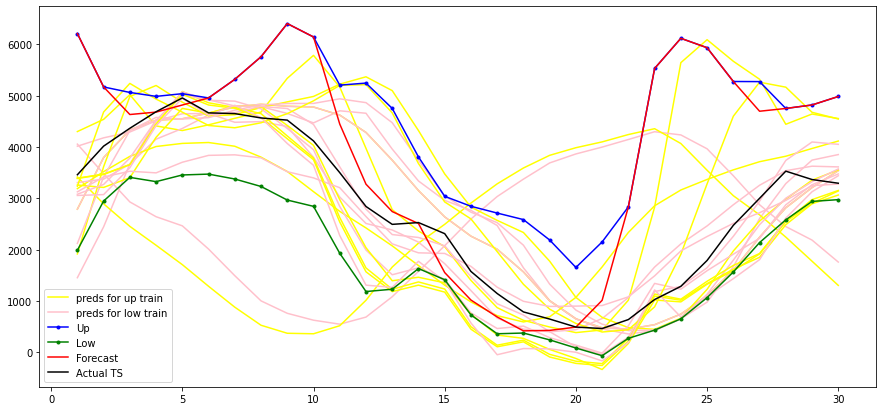

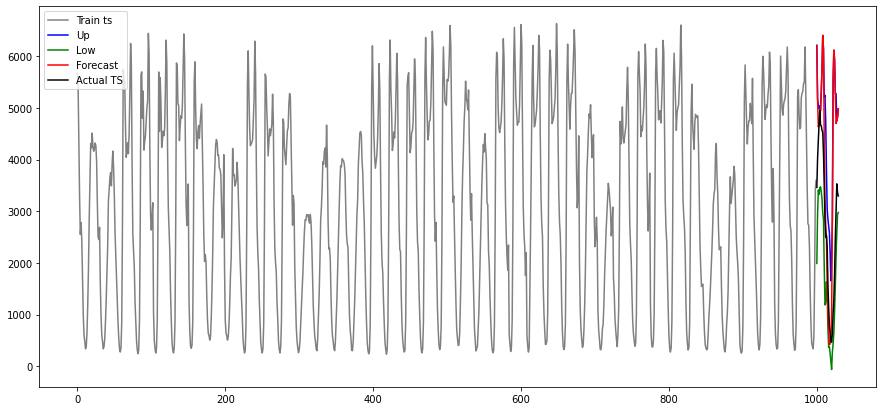

In [50]:
conf_int_plotting(up_predictions = x['up_predictions'],
                  low_predictions = x['low_predictions'],
                  regim='quantile',
                  plot_history = True,
                  plot_up_int = True,
                  plot_low_int = True,
                  plot_trend = False,
                  plot_forecast = True,
                  plot_upper_train = True,
                  plot_lower_train = True,
                  plot_ts_test = True)